# Reducing News Reading Time with Transformer-Based Summaries
Author: Andrii Zapukhlyi

## Objective
In today’s fast-paced world, a constant stream of news makes it difficult for people to stay informed—especially about political events—without spending a lot of time reading full articles. The goal is to help users quickly grasp key information without sacrificing understanding.

## Solution
To address this issue, I will develop an automatic news summarization system that generates concise and informative summaries using deep learning techniques. The solution centers on Transformer-based models, which have proven to outperform traditional architectures like LSTMs in NLP tasks, providing faster and more accurate access to essential content.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import spacy
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import evaluate

import datasets
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSeq2SeqLM

## Data overview

In [2]:
dataset = datasets.load_dataset("cnn_dailymail", "3.0.0")

For this project, I will use a popular news summarization dataset consisting of scraped CNN news articles. This dataset provides pairs of full news stories and their corresponding human-written summaries.

In [3]:
train = pd.DataFrame(dataset["train"])
test = pd.DataFrame(dataset["test"])
val = pd.DataFrame(dataset["validation"])

In [4]:
train.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


From the first five observations, it's clear that the articles contain metadata, which would act as noise for the model during training. Therefore, I will remove this metadata to ensure the model focuses only on the content of the articles.

In [5]:
print(len(train), len(val), len(test))

287113 13368 11490


The full dataset contains over 287,000 articles for training. To begin, I will reduce this number to the first 50,000 articles in order to build a baseline model and evaluate whether it's feasible to perform news summarization using the selected architectures.

In [6]:
train = train.head(50000)

In [7]:
train.sample(10)

,article,highlights,id
14294,New York (CNN) -- Iranian President Mahmoud Ah...,Iran president made annual trip to New York fo...,82b05bc75d9dce53847850b32e11ed499f8d84d4
24010,"LONDON, England (CNN) -- After four years and...",The EU and U.S. have begun talks for phase II ...,5d32b76ce3bd993100a8fa016cac4e2e39156904
49412,(CNN) -- After a rocket landed late Saturday i...,"Israel says a rocket fired from Gaza landed, c...",ff59041d0f2646f0ee5a361c069cbf00e6f80b3d
20813,"(PEOPLE.com) -- Ali Landry and her husband, di...",Ali Landry and her husband welcomed their seco...,2e81656515a81bd5c6bf8e3ed516fadedc7d214b
12636,(CNN) -- Judges have approved British supermod...,Supermodel Naomi Campbell requested the delay ...,e0ed8a478fee8ea689b251341050ecf2f13f7f06
41525,(CNN) -- Annie Leibovitz on Monday defended he...,Vanity Fair photographer Annie Leibovitz: Pict...,ce3a7fcf00b1ab7cbb73b51c80818c6f7b4d9c4c
10589,"(CNN) -- Chesley ""Sully"" Sullenberger: On Janu...","'Miracle on Hudson' pilot Chesley ""Sully"" Sull...",92d4f58c11c930173076f8d8d592f9032b86076f
21041,"Jos, Nigeria (CNN) -- An Islamic militant grou...",Sectarian violence and fuel policy protests ar...,30c74bacfcc152db0eaafcc1dd0df893776de451
7536,(CNN) -- A Singapore-flagged container ship hi...,Hijacked Chinese bulk carrier De Xin Hai relea...,e468919a95a62ce8ba9415b9ba8d72b1ac2dc5f9
9342,(CNN) -- The number of girls being raped has i...,Aid group says rape reports increase as fighti...,fcca20f58f8ed4464aa694d34dc2fbba6a5d99d9


In [8]:
train.describe()

,article,highlights,id
count,50000,50000,50000
unique,47883,47547,50000
top,(CNN) -- Conjoined Egyptian twin boys Hassan a...,The daily transcript is a written version of e...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
freq,3,69,1


The summary shows that the most frequent highlight, which appears 69 times, doesn't really seem to be a proper summary of the article. Because of that, I'll check an example of an article that has this highlight.

In [9]:
wrong_index = train[train["highlights"].str.startswith("The daily transcript is a written version", na=False)].index[0]
print(train.loc[wrong_index, "article"])
print("**************")
print(train.loc[wrong_index, "highlights"])

(CNN Student News) -- October 21, 2011 . Download PDF maps related to today's show: . Libya . New York City & Los Angeles . Click here to access the transcript of today's CNN Student News program. Please note that there may be a delay between the time when the video is available and when the transcript is published.
**************
The daily transcript is a written version of each day's CNN Student News program .
Use this transcript to help students with reading comprehension and vocabulary .
Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News .


Since this highlight is not actual news content, I will remove all entries containing this information from the dataset.

In [10]:
def delete_wrong_scraped(set):
    wrong_scraped = ["This page includes the show Transcript", "The daily transcript is a written version", "Use the weekly Newsquiz to test your", "Use these questions to help students understan"]

    for elem in wrong_scraped:
        set = set[~set['highlights'].str.contains(elem, na=False, case=False)]

    return set

train = delete_wrong_scraped(train)
val = delete_wrong_scraped(val)
test = delete_wrong_scraped(test)

In [11]:
print(train.describe())
print(val.describe())
print(test.describe())

                                                  article  \
count                                               49764   
unique                                              47647   
top     (CNN) -- Dubai could lose its place on the Wom...   
freq                                                    3   

                                               highlights  \
count                                               49764   
unique                                              47509   
top     Rick Steves writes European travel guidebooks ...   
freq                                                    8   

                                              id  
count                                      49764  
unique                                     49764  
top     42c027e4ff9730fbb3de84c1af0d2c506e41c3e4  
freq                                           1  
                                                  article  \
count                                               13351   
unique     

In [12]:
print("Number of NA values in train set:", train.isna().sum().sum())
print("Number of NA values in val set:", val.isna().sum().sum())
print("Number of NA values in test set:", test.isna().sum().sum())

print("Number of duplicates in train set:", train.duplicated().sum())
print("Number of duplicates in val set:", val.duplicated().sum())
print("Number of duplicates in test set:", test.duplicated().sum())

Number of NA values in train set: 0
Number of NA values in val set: 0
Number of NA values in test set: 0
Number of duplicates in train set: 0
Number of duplicates in val set: 0
Number of duplicates in test set: 0


There are no missing values or duplicated rows in the dataset.

## Data Visualization

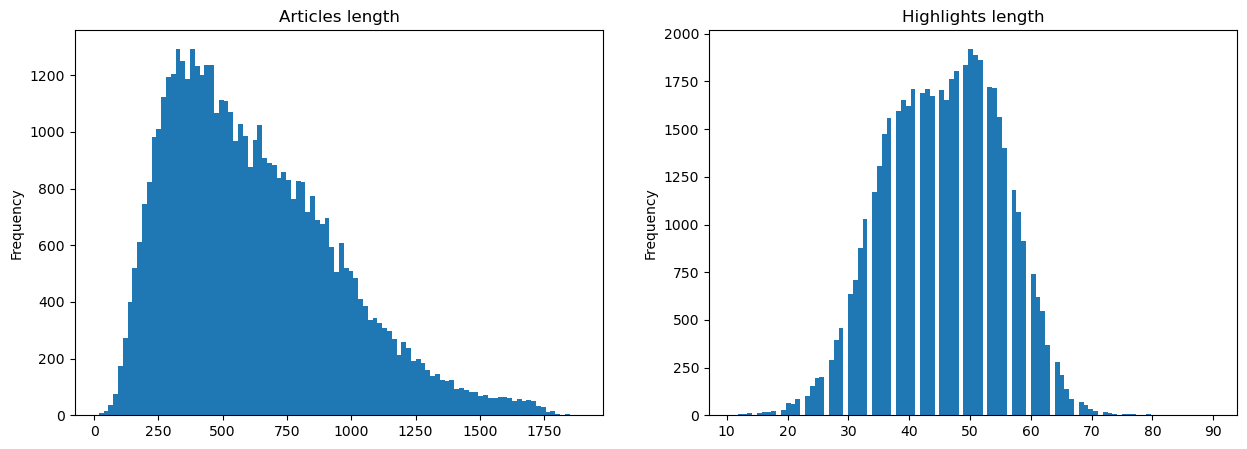

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

train["article"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100, ax = ax[0])
ax[0].set_title('Articles length')

train["highlights"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100, ax = ax[1])
ax[1].set_title('Highlights length')

plt.show()

Above are histograms showing the distribution of article and highlight lengths. The article length distribution is right-skewed, with the most common word count falling between 250 and 500 words. The highlight distribution is approximately normal, with a mean of around 50 words. Based on these charts, it can be concluded that this project is worthwhile. Since reading a full article of 500 words can be time-consuming, having a concise summary allows readers to quickly access the key information without unnecessary details.

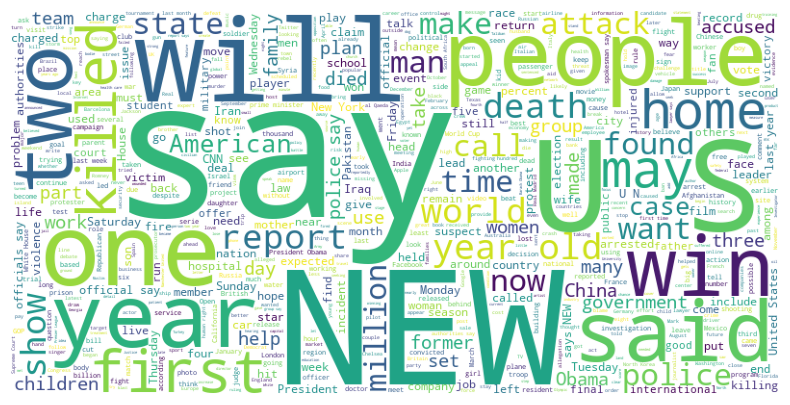

In [14]:
text_data = " ".join(train['highlights'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=1000).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The WordCloud graph shows that the most frequent words in the training highlights are 'new,' 'say,' 'will,' and 'one.'

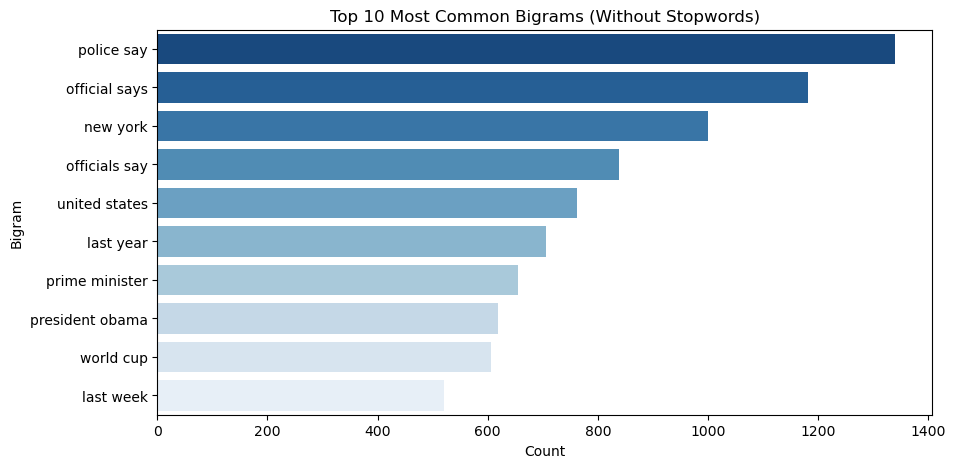

In [15]:
stop_words = set(stopwords.words("english"))

def get_bigrams(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    bigrams = list(nltk.bigrams(words))
    return [" ".join(bigram) for bigram in bigrams]

bigrams = []
for t in train["highlights"]:
    bigrams.extend(get_bigrams(t))

bigram_counts = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")
plt.title("Top 10 Most Common Bigrams (Without Stopwords)")
plt.show()

The most popular bigrams, after removing stopwords (e.g., "all," "this"), are shown above. The most frequent bigram, "police say," appeared more than 1,300 times.

## Data cleaning

First, I will remove metadata from the articles, such as author names, sources, and others, using the `re` library.

In [16]:
metadata_pattern = re.compile(
    r"^By\s+.*?\.\s+"  # Removes "By . Author Name ."
    r"|PUBLISHED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*\s*\|?\s*UPDATED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*"  # Removes PUBLISHED / UPDATED timestamps
    r"|Last updated at \d{1,2}:\d{2} [APM]{2} on \d{1,2}(st|nd|rd|th)? \w+ \d{4} \."  # Removes "Last updated at ..."
    r"|^.*?--\s*"  # Removes source prefixes like "(CNN) --", "(BBC) --"
    r"|^Follow\s+@@\S+\s+\.\s+"  # Removes "Follow @username . "
    r"|UPDATED: .*? \. "  # Removes text after "UPDATED: ..."
)

def delete_metadata(text):
    if not isinstance(text, str):
        return text
    
    text = metadata_pattern.sub('', text)
    return ' '.join(text.split())

train["article"] = train["article"].apply(delete_metadata)
val["article"] = val["article"].apply(delete_metadata)

In [17]:
def clean_text(text_series):
    text_series = text_series.str.lower()

    text_series = text_series.str.replace(r"http\S+|www\S+|https\S+", '', regex=True)
    text_series = text_series.str.replace(r"@\w+|#\w+", '', regex=True)
    text_series = text_series.str.replace(r"([.,!?])", r" \1 ", regex=True)
    text_series = text_series.str.replace(r'\n+', ' ', regex=True)
    text_series = text_series.str.strip()
    return text_series

train["article"] = clean_text(train["article"])
train["highlights"] = clean_text(train["highlights"])

val["article"] = clean_text(val["article"])
val["highlights"] = clean_text(val["highlights"])

Additionally, unnecessary symbols such as hyperlinks, mentions, punctuation, and empty rows are removed.

In [18]:
train = train.dropna()
val = val.dropna()

## Tokenization

Tokenization is a necessary step in building NLP models, which involves splitting each sentence into a list of words. I will performe tokenization in batches to avoid running into memory issues. Both X and y will be tokenized.

In [19]:
nlp = spacy.load("en_core_web_sm")

def tokenize_text(texts):
    texts = list(texts)
    return [[token.text for token in doc] for doc in nlp.tokenizer.pipe(texts, batch_size=128)]

X_train_tokenized = tokenize_text(train["article"])
y_train_tokenized = tokenize_text(train["highlights"])
X_val_tokenized = tokenize_text(val["article"])
y_val_tokenized = tokenize_text(val["highlights"])

## Vocabulary building

In the vocabulary, I will initialize the following indexes for specific tags:

- 0 for padding, which will be implemented in the next step
- 1 for unknown words, those outside the vocabulary
- 2 for the start of the sentence, necessary for Seq2Seq models, especially for the Decoder
- 3 for the end of the sentence, similar to the start of the sentence tag

In [20]:
all_tokens = [token for tokens in (X_train_tokenized + y_train_tokenized) for token in tokens]
word_counts = Counter(all_tokens)

vocab = {
    "<PAD>": 0,
    "<UNK>": 1,
    "<SOS>": 2,
    "<EOS>": 3
}

start_idx = 4
max_vocab_size = 50000

for token, _ in word_counts.most_common(max_vocab_size):
    if token not in vocab:
        vocab[token] = start_idx
        start_idx += 1

def encode(tokens, vocab):
    return np.array([vocab.get(token, vocab["<UNK>"]) for token in tokens], dtype=np.int32)

X_train_idx = [encode(tokens, vocab) for tokens in X_train_tokenized]
Y_train_idx = [[vocab["<SOS>"]] + encode(tokens, vocab).tolist() + [vocab["<EOS>"]] for tokens in y_train_tokenized]
X_val_idx = [encode(tokens, vocab) for tokens in X_val_tokenized]
Y_val_idx = [[vocab["<SOS>"]] + encode(tokens, vocab).tolist() + [vocab["<EOS>"]] for tokens in y_val_tokenized]

In [21]:
print("Vocabulary size:", len(vocab))

Vocabulary size: 50004


## Padding

I will set the maximum padding length as the maximum of the article lengths in the training dataset.

In [44]:
MAX_LEN = max(len(tokens) for tokens in X_train_tokenized)

def pad_sequences(sequences, max_len=MAX_LEN, pad_idx=0):
    tensor_sequences = [torch.tensor(seq[:max_len], dtype=torch.long) for seq in sequences]
    return pad_sequence(tensor_sequences, batch_first=True, padding_value=pad_idx)

X_train_padded = pad_sequences(X_train_idx, pad_idx=vocab["<PAD>"])
Y_train_padded = pad_sequences(Y_train_idx, pad_idx=vocab["<PAD>"])
X_val_padded = pad_sequences(X_val_idx, pad_idx=vocab["<PAD>"])
Y_val_padded = pad_sequences(Y_val_idx, pad_idx=vocab["<PAD>"])

In [45]:
print(X_train_padded.shape, Y_train_padded.shape)

torch.Size([49764, 2947]) torch.Size([49764, 116])


In [46]:
class SummarizationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = SummarizationDataset(X_train_padded, Y_train_padded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## LSTM Seq2Seq Model
<img src = "https://miro.medium.com/v2/resize:fit:1400/1*Ismhi-muID5ooWf3ZIQFFg.png" alt = "seq2seq architecture">
<p>The Seq2Seq model architecture consists of two main components: the Encoder and the Decoder. The Encoder processes the input sequence and transforms it into a context vector, which—when using an LSTM—includes both a hidden state and a cell state. This context vector is then passed to the Decoder as its initial hidden and cell states. The Decoder starts by receiving a special <SOS> (Start-of-Sentence) token as its first input. From there, it generates the output sequence step by step, using the context vector and its own previous predictions. The final output is a summarized version of the input news article.</p>

In [47]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        _, (hidden, cell) = self.rnn(embedding)
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.output_size = output_size
        
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        predictions = self.fc(output.squeeze(1))
        return predictions, hidden, cell
    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

I’ve implemented the Encoder and Decoder classes with their respective architectures, and wrapped them in a Seq2Seq class that handles passing the context vector from the Encoder to the Decoder correctly.

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
num_epochs = 3
num_batches = len(train_loader)
total_batches = num_epochs * num_batches
print("Total batches:", total_batches)

Total batches: 4668


In [50]:
encoder = Encoder(len(vocab), 256, 50, 1)
decoder = Decoder(len(vocab), 256, 50, 1)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

model.train()

start_time = time.time()

X_batch, y_batch = next(iter(train_loader))

X_batch, y_batch = X_batch.to(device), y_batch.to(device)
optimizer.zero_grad()
output = model(X_batch, y_batch)
output = output[:, 1:].reshape(-1, output.shape[2])
y_batch = y_batch[:, 1:].reshape(-1)

loss = criterion(output, y_batch)
loss.backward()
optimizer.step()

batch_time = time.time() - start_time
estimated_total_time = (batch_time * total_batches)
print(f"Time per batch: {batch_time:.2f}s - Estimated Total Time: {estimated_total_time // 60:.2f} min")

Time per batch: 0.30s - Estimated Total Time: 23.00 min


The estimated training time for a Seq2Seq LSTM model with a single layer and 50 neurons on 50,000 observations for just 3 epochs is around 23 minutes. Even if trained, the model would likely be underfitted, as such a simple architecture and limited training duration are insufficient for complex tasks like news summarization or other sequence-to-sequence applications. Moreover, RNN-based models like LSTM have now been fully replaced in most NLP tasks by Transformers, which represent the new state-of-the-art in the field.

In [51]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of Parameters in basic LSTM model: {total_params:,}")

Number of Parameters in basic LSTM model: 28,275,452


## LSTM with an Attention Mechanism (for Practice)
In this section, I implement an Attention Mechanism, which can improve prediction quality by assigning different weights to different words in the input. Since not all words contribute equally to the meaning of a sentence, attention helps the model focus on the most relevant parts. I won’t train the model with attention in this case, as it’s not needed. This implementation is purely for practice and to gain a better understanding of how attention works in PyTorch.

In standard Seq2Seq models, a single context vector is passed from the Encoder to the Decoder. While this works well for short sentences, it struggles with longer texts because the context vector is fixed and doesn’t contain all the necessary information for the Decoder. As a result, predictions become less accurate. The attention mechanism in RNNs creates a context vector at each time step, enabling the model to better handle long-range dependencies in the text.

<img height = 600, width = 600, src = "https://machinelearningmastery.com/wp-content/uploads/2021/09/bahdanau_1.png" alt = "bahdanau attention mechanism">
<p>Attention Mechanism in RNNs</p>
<p>The symbol ⊕ represents the weighted average of the weights and outputs from the Encoder. The weights are computed as the output of a small neural network, which takes as input the previous Decoder output (s_(t-1)) and the current Encoder output (h_t). Additionally, before calculating the weighted average, the weights are normalized using the softmax function to ensure they sum to 1. This approach helps the model make more accurate predictions. Besides, there is another method for calculating weights, such as Luong Attention.</p>

I will reimplement the Encoder, Decoder, and Seq2Seq wrapper classes, as there are some minor structural changes. Additionally, I will redefine Dataloader to reduce the number of batches.

In [52]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [53]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedding)
        return output, hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, encoder_hidden_size, decoder_hidden_size, num_layers, attention):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size + encoder_hidden_size, decoder_hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(decoder_hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)

        rnn_input = torch.cat((embedding, context), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        predictions = self.fc(output.squeeze(1))
        return predictions, hidden, cell


class Attention(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(encoder_hidden_size + decoder_hidden_size, decoder_hidden_size)
        self.v = nn.Linear(decoder_hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)



class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

In [58]:
encoder = Encoder(len(vocab), 256, 50, 1)
attention = Attention(50, 50)
decoder = Decoder(len(vocab), 256, 50, 50, 1, attention)
model_w_attention = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model_w_attention.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

model_w_attention.train()

start_time = time.time()

X_batch, y_batch = next(iter(train_loader))

X_batch, y_batch = X_batch.to(device), y_batch.to(device)
optimizer.zero_grad()
output = model_w_attention(X_batch, y_batch)
output = output[:, 1:].reshape(-1, output.shape[2])
y_batch = y_batch[:, 1:].reshape(-1)

loss = criterion(output, y_batch)
loss.backward()
optimizer.step()

batch_time = time.time() - start_time
estimated_total_time = (batch_time * total_batches)
print(f"Time per batch: {batch_time:.2f}s - Estimated Total Time: {estimated_total_time // 60:.2f} min")

Time per batch: 0.32s - Estimated Total Time: 24.00 min


In [59]:
total_params = sum(p.numel() for p in model_w_attention.parameters())
print(f"Number of Parameters in basic LSTM model: {total_params:,}")

Number of Parameters in basic LSTM model: 28,290,552


## Transformer model

In [ ]:
train_data = dataset["train"]
val_data = dataset["validation"]

In [ ]:
def delete_wrong_scraped(example):
    wrong_scraped = [
        "This page includes the show Transcript", 
        "The daily transcript is a written version", 
        "Use the weekly Newsquiz to test your", 
        "Use these questions to help students understan"
    ]
    
    for elem in wrong_scraped:
        if isinstance(example["highlights"], str) and elem.lower() in example["highlights"].lower():
            return None
    return example

def clean_text(example):
    example["article"] = delete_metadata(example["article"])
    example["highlights"] = delete_metadata(example["highlights"])
    return delete_wrong_scraped(example)


train_data = train_data.map(clean_text, batched=False)
val_data = val_data.map(clean_text, batched=False)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

In [ ]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def tokenize_data(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=128)
    
    inputs["labels"] = targets["input_ids"]
    return inputs

train_data = train_data.map(tokenize_data, batched=True)
val_data = val_data.map(tokenize_data, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/286631 [00:00<?, ? examples/s]

Map:   0%|          | 0/13351 [00:00<?, ? examples/s]

In [ ]:
batch_size = 8

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 28,275,452


In [ ]:
#trainer.train()

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("results/checkpoint-18663")
model.to("cuda")

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
def summarize(text, max_input_length=512, max_output_length=128, device="cuda"):
    model.to(device)

    inputs = tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True)

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        summary_ids = model.generate(
            **inputs, 
            max_length=max_output_length, 
            num_beams=5, 
            early_stopping=True
        )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
sample_text = val_data["article"][3]
summary = summarize(sample_text)
print("Original Article:\n", sample_text)
print("\nGenerated Summary:\n", summary)

Original Article:
 (CNN)It was an act of frustration perhaps more commonly associated with golf's fictional anti-hero Happy Gilmore than the world's reigning No 1. player. But when Rory McIlroy pulled his second shot on the eighth hole of the WGC Cadillac Championship into a lake Friday, he might as well have been channeling the much loved Adam Sandler character. Before continuing his round with a dropped ball, the four-time major winner launched the 3-iron used to play the offending shot into the water as well. "(It) felt good at the time," a rueful McIlroy later said of the incident in comments carried by the PGA Tour website. "I just let frustration get the better of me. It was heat of the moment, and I mean, if it had of been any other club I probably wouldn't have but I didn't need a 3‑iron for the rest of the round so I thought, why not." The club "must have went a good 60, 70 yards," he joked. McIlroy composed himself to finish with a second round of 70, leaving him one-under fo

In [ ]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def compute_metrics(predictions, references):
    predictions = [pred.strip() for pred in predictions]
    references = [[ref.strip()] for ref in references]

    bleu_score = bleu_metric.compute(predictions=predictions, references=references)
    rouge_score = rouge_metric.compute(predictions=predictions, references=references)

    return {"bleu": bleu_score["bleu"], "rouge": rouge_score}

predictions = [summarize(article) for article in val_data["article"][:10]]
references = [ref for ref in val_data["highlights"][:10]]


metrics = compute_metrics(predictions, references)
print(metrics)

{'bleu': 0.03287414667535105, 'rouge': {'rouge1': 0.17546257110475455, 'rouge2': 0.03293818515592368, 'rougeL': 0.1349394470087316, 'rougeLsum': 0.13465718975753085}}


In [ ]:
samplex_text = """

A unique report on a secret Soviet-era military facility reveals the details of an underground command post hidden in the forests near Ivano-Frankivsk, which could once have become the epicenter of a global confrontation.

Halka writes about this with reference to video blogger Mark Bobalik in his study of abandoned military facilities in the Carpathian region.

The hidden heart of the Cold War, a huge underground complex that could once accommodate 450 top military officials and withstand a powerful nuclear strike, has now turned into a terrifying monument to Soviet military power. Located in the picturesque Black Forest near Ivano-Frankivsk, this top-secret facility was a real fortress, capable of operating autonomously for three weeks.

The command post was a true engineering masterpiece of the Soviet era. Suspended on 36 steel cables, with a unique nitrogen shock absorption system, it was designed to withstand even the most powerful impacts. Special cylinders maintained internal pressure, preventing the ingress of toxic substances, and the furniture was securely fixed on a special raised floor with foam filler.

The uniqueness of the facility lay in its communication capabilities. From here, the troops of 15 Warsaw Pact countries were controlled, 600 telephone and one and a half thousand telegraph channels operated. The system was duplicated by radio communication, relay, tropospheric and space communication channels.

Interestingly, in 2005, the local authorities planned to transform the unique complex into a tourist and recreational facility and a center for medical prevention. However, these plans remained unrealized. Currently, the premises are under the management of the State Emergency Service and are used as ordinary warehouses.

Mark Bobalik recorded the condition of the facility during his research: flooded tunnels, damaged metal structures, complete lack of security. Once the pride of Soviet military power, it has turned into a terrible monument of the past, a silent witness to the Cold War era.

Today, only fragments remain of its former greatness: damaged entrances, cut-off antennas and flooded premises. The only thing that has remained unchanged is the picturesque forest lands around, where the largest population of red deer in the Carpathian region still lives.

This facility is not just an abandoned place, but a real museum of Soviet-era technical thought, waiting for its rebirth and rethinking.
"""

In [ ]:
summarize(samplex_text)

'A secret Soviet-era military facility is hidden in the forests near Ivano-Frankivsk. It was a real fortress capable of operating autonomously for three weeks. The complex was a true engineering masterpiece of the Soviet era.'

In [ ]:
compute_metrics([summarize(val_data["article"][3])], [(val_data["highlights"][3])])

{'bleu': 0.05060454076656146,
 'rouge': {'rouge1': 0.19753086419753085,
  'rouge2': 0.10126582278481013,
  'rougeL': 0.19753086419753085,
  'rougeLsum': 0.19753086419753085}}

In [ ]:
summarize(val_data["article"][3])

'Rory McIlroy pulls his second shot on the eighth hole of the WGC Cadillac Championship. The four-time major winner launches the 3-iron used to play the offending shot into the water. McIlroy finished with a second round of 70, leaving him one-under for the tournament. Ryan Holmes scores a two-under-par 71 to remain in second position overall.'

In [ ]:
val_data["highlights"][3]

'Rory McIlroy throws club into water at WGC Cadillac Championship . Northern Irishman frustrated after pulling shot into water hazard .'